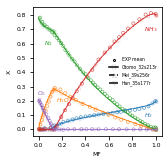

→ Saved combined plot at: figs/validation/validation_all_species.pdf


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# ─── User‐adjustable settings ──────────────────────────────────────────────────

# 1) Where your EXPERIMENTAL CSVs live (each two‐column, no header):
exp_dir = "EXP_data/exp"

# 2) Root of all SIMULATION folders:
#    Each CSV is at SIM_results/<case_name>/<mech>/<target_case>.csv
method_path = "SIM_results"

# 3) Which “case_name” subfolder to look under:
case_name = "case_NH3_counterflow_KAUST"

# 4) The list of mechanism‐folder names you want to compare:
mechanisms = [
    "Otomo_32s213r",
    # "KAUST_32s243r",
    "Mei_39s256r",
    "Han_35s177r",
    # "Marshall_33s221r",
    # "Sandiego_19s40r"
]

# 5) The list of your target_cases (same as when you ran QSSA):
target_case_assemble = [
    "N_CF_1",
    # add more if needed
]

# pick up the ten Tab10 colors:
cmap = plt.get_cmap('tab10')
color_arr = list(cmap.colors)    # gives you 10 RGBA tuples

# 7) Marker symbols to cycle through for each mechanism:
symbol_arr = ['s', '^', 'v', '*', 'D', 'X']

# 8) Line styles to cycle through for each mechanism (only three as requested)
line_arr = ['-','--', '-.', ':']

# 9) Dictionary of manual text offsets (dx, dy) for each species.
text_offsets = {
    "H2":   (0.9,  0.1),
    "H2O":  (0.15, 0.2),
    "N2":   (0.05, -0.18),
    "NH3":  (0.9,  0.7),
    "O2":   (-0.01, 0.04),
    # add more species here as needed...
}

species_display_names = {
    "H2":  r"$H_2$",
    "H2O": r"$H_2O$",
    "O2":  r"$O_2$",
    "N2":  r"$N_2$",
    "NH3": r"$NH_3$",
    # Add more as needed...
}
# 10) Where to dump the combined validation PDF:
output_dir = "figs/validation"
os.makedirs(output_dir, exist_ok=True)


# ─── Helper: read two‐column, no‐header CSV into columns x,y ───────────────────
def read_two_column_csv(path):
    """
    Reads a CSV with exactly two columns and no header.
    Returns a DataFrame with columns “x” and “y”.
    """
    return pd.read_csv(path, header=None, names=["x", "y"])


# ─── Gather all species names (skip “T.csv”) ────────────────────────────────────
species_list = []
for fname in sorted(os.listdir(exp_dir)):
    if not fname.lower().endswith(".csv"):
        continue
    name = fname[:-4]
    if name.upper() == "T":
        continue
    species_list.append(name)

if not species_list:
    raise RuntimeError("No experimental species files found (besides T.csv).")


# ─── Set up a single, narrow figure: width = 192 pt ≈ 2.667 in; height = 2.6 in ────
plt.figure(figsize=(2.367, 2.3))


# ─── Plot each species + mechanism ─────────────────────────────────────────────
for i, species in enumerate(species_list):
    # Assign a color for this species
    color = color_arr[i % len(color_arr)]

    # 1) Read EXPERIMENTAL data and sort by x
    exp_path = os.path.join(exp_dir, f"{species}.csv")
    try:
        df_exp = read_two_column_csv(exp_path)
    except Exception as e:
        print(f"  → Skipping EXP data for {species}: could not read ({e})")
        continue

    df_exp = df_exp.sort_values(by="x")

    # Plot EXP as scatter with hollow markers
    plt.scatter(
        df_exp["x"],
        df_exp["y"],
        facecolors="none",         # hollow interior
        edgecolors=color,          # edge matches species color
        linewidth=0.6,
        s=10,                      # marker size
        alpha=0.8,
        marker="o"
    )

    # Variables to store coordinates for the species text label
    last_x = None
    last_y = None

    # 2) For each mechanism, plot SIM “X_<species> vs. MF” with hollow marker and requested linestyles
    for j, mech in enumerate(mechanisms):
        sim_marker = symbol_arr[j % len(symbol_arr)]
        sim_linestyle = line_arr[j % len(line_arr)]

        for tc in target_case_assemble:
            qssa_path = os.path.join(
                method_path,
                case_name,
                mech,
                f"{tc}.csv"
            )
            if not os.path.isfile(qssa_path):
                continue

            df_qssa = pd.read_csv(qssa_path)
            ycol = f"X_{species}"
            if ycol not in df_qssa.columns or "MF" not in df_qssa.columns:
                continue

            x_values = df_qssa["MF"]
            y_values = df_qssa[ycol]

            plt.plot(
                x_values,
                y_values,
                color=color,               # same species color
                linewidth=0.6,
                alpha=0.9,
                marker=sim_marker,
                markerfacecolor="none",    # hollow interior
                markeredgecolor=color,     # edge matches species color
                markeredgewidth=0.1,       # fine edge
                linestyle=sim_linestyle,   # one of '--', '-.', ':'
                markersize=3,
                markevery=max(len(x_values)//20, 1)
            )

            # Update last point
            if len(x_values) > 0:
                last_x = x_values.values[-1]
                last_y = y_values.values[-1]

    # 3) Add text label for the species, in its color
    if last_x is not None and last_y is not None:
        dx, dy = text_offsets.get(species, (0.02, 0.0))
        
        plt.text(
            last_x + dx,
            last_y + dy,
            species_display_names.get(species, species),
            color=color,
            fontsize=6,
            verticalalignment='center',
            horizontalalignment='left'
        )


# ─── Build proxy handles for a compact legend ───────────────────────────────────
#  A) One proxy for experimental (“exp_mean”)
exp_handle = Line2D(
    [0], [0],
    color='k',
    marker='o',
    markerfacecolor="none",
    markeredgecolor="k",
    linestyle="None",
    markersize=2,
    label='EXP mean'
)

#  B) One proxy per mechanism (black hollow marker + linestyle)
mechanism_handles = [exp_handle]
for j, mech in enumerate(mechanisms):
    sim_marker = symbol_arr[j % len(symbol_arr)]
    sim_linestyle = line_arr[j % len(line_arr)]
    h = Line2D(
        [0], [0],
        color="k",
        marker=sim_marker,
        markerfacecolor="none",
        markeredgecolor="k",
        markeredgewidth=0.1,
        linestyle=sim_linestyle,
        markersize=4,
        label=mech
    )
    mechanism_handles.append(h)


# ─── Final formatting ───────────────────────────────────────────────────────────
plt.xlabel("MF", fontsize=6)
plt.ylabel("X", fontsize=6)

# Set tick label size to 6
plt.tick_params(axis='both', which='major', labelsize=6)

# Legend: first entry “exp_mean”, then mechanisms
plt.legend(
    handles=mechanism_handles,
    fontsize=4.5,
    loc="best",
    ncol=1,
    framealpha=0
)

plt.tight_layout(pad=0.8)  # slight padding


# ─── Save combined figure ──────────────────────────────────────────────────────
out_file = os.path.join(output_dir, "validation_all_species.pdf")
plt.savefig(out_file, dpi=300)
plt.show()

print(f"→ Saved combined plot at: {out_file}")